In [1]:
# pip install gputools
# pip install scikit-tensor-py3

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import cv2
import pandas as pd

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [2]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [3]:
pth=r'\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations'
pthtraining= os.path.join(pth,'Training')
pthtesting= os.path.join(pth,'Testing')
pthmodels= os.path.join(pth,'models')
pthfiles= os.path.join(pth,'files')

# pthHE= r'\\10.99.68.178\andreex\data\Stardist\Training\H&E_tiles'
# pthmasks= r'\\10.99.68.178\andreex\data\Stardist\Training\masks'

pthHE = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\training_and_testing_monkey_12_7_23\training\images'
pthmasks = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\training_and_testing_monkey_12_7_23\training\masks'

In [4]:
pthmodels

'\\\\10.99.68.178\\andreex\\data\\Stardist\\qupath_training_annotations\\models'

In [5]:
training_HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
training_mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

In [6]:
training_HE_tiles_pths

['\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\stardist\\training_and_testing_monkey_12_7_23\\training\\images\\fallopian_tubes_AJER376_035.tif',
 '\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\stardist\\training_and_testing_monkey_12_7_23\\training\\images\\fallopian_tubes_AJER376_117.tif',
 '\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\stardist\\training_and_testing_monkey_12_7_23\\training\\images\\fallopian_tubes_AJER376_157.tif',
 '\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\stardist\\training_and_testing_monkey_12_7_23\\training\\images\\fallopian_tubes_AJER376_217.tif',
 '\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\stardist\\training_and_testing_monkey_12_7_23\\training\\images\\fallopian_tubes_AJER376_235.tif',
 '\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\stardist\\training_and_testing_monkey_12_7_23\\training\\images\\fallopian_tubes_AJER376_245.tif',
 '\\\\10.99.68.178\\andreex\\students\\Donald 

In [7]:
print(len(training_HE_tiles_pths))
print(len(training_mask_tiles_pths))

38
38


In [8]:
HE_original_tiles = list(map(imread,training_HE_tiles_pths))
mask_original_tiles = list(map(imread,training_mask_tiles_pths))

In [9]:
import random

size_total = len(training_HE_tiles_pths)
print(f'Size total: {size_total}')

val_ratio = 0.3
num_indices = int(size_total * val_ratio)

print(f'Size Training: {size_total - num_indices}')
print(f'Size Validation: {num_indices}')

Size total: 38
Size Training: 27
Size Validation: 11


In [10]:
val_indices = sorted(random.sample(range(size_total), num_indices))
train_indices = sorted(list(set(range(size_total)) - set(val_indices)))

print(val_indices)
print(train_indices)

[5, 6, 9, 11, 15, 20, 23, 27, 31, 33, 37]
[0, 1, 2, 3, 4, 7, 8, 10, 12, 13, 14, 16, 17, 18, 19, 21, 22, 24, 25, 26, 28, 29, 30, 32, 34, 35, 36]


In [11]:
training_tiles = [HE_original_tiles[i] for i in train_indices]
training_masks = [mask_original_tiles[i] for i in train_indices]

val_tiles = [HE_original_tiles[i] for i in val_indices]
val_masks = [mask_original_tiles[i] for i in val_indices]

print(len(training_tiles))
print(len(training_masks))

print(len(val_tiles))
print(len(val_masks))

27
27
11
11


In [12]:
def augment_images(HE_tiles, mask_tiles):
  """
  Augments a set of HE images and corresponding mask labels by rotating and flipping them.

  Args:
    HE_tiles: A list of NumPy arrays representing the HE images.
    mask_tiles: A list of NumPy arrays representing the mask labels for the HE images.

  Returns:
    HE_aug: A list of NumPy arrays representing the augmented HE images.
    mask_aug: A list of NumPy arrays representing the augmented mask labels.
  """

  HE_aug = [[] for _ in range(len(HE_tiles))]
  mask_aug = [[] for _ in range(len(mask_tiles))]

  for i in range(len(HE_tiles)):
    im = Image.fromarray(HE_tiles[i])
    lbl = Image.fromarray(mask_tiles[i])

    # Rotate the image and label 90 degrees three times.
    for _ in range(3):
      im = im.rotate(90)
      HE_aug[i].append(im)
      lbl = lbl.rotate(90)
      mask_aug[i].append(lbl)

    # Flip the image and label horizontally.
    im = Image.fromarray(HE_tiles[i])
    flipped_im = im.transpose(Image.FLIP_LEFT_RIGHT)

    lbl = Image.fromarray(mask_tiles[i])
    flipped_lbl = lbl.transpose(Image.FLIP_LEFT_RIGHT)

    HE_aug[i].append(flipped_im)
    mask_aug[i].append(flipped_lbl)

    # Rotate the flipped image and label 90 degrees three times.
    for _ in range(3):
      flipped_im = flipped_im.rotate(90)
      HE_aug[i].append(flipped_im)
      flipped_lbl = flipped_lbl.rotate(90)
      mask_aug[i].append(flipped_lbl)

  return HE_aug, mask_aug

In [13]:
HE_aug, mask_aug = augment_images(training_tiles, training_masks)

In [14]:
print(len(training_tiles))

27


In [15]:
print(len(HE_aug)*(len(HE_aug[0])))
print(len(mask_aug)*(len(mask_aug[0])))

189
189


In [16]:
def normalize_images(images, masks):
  
  normalized_masks = [[] for i in range(len(masks))]
  normalized_images = [[] for i in range(len(images))]
  
  for i in range(len(masks)):
      masks_list = masks[i]
      images_list = images[i]
      
      for j in range(len(images_list)):
          im = images_list[j]
          im = np.asarray(im)
          im = im/255
          normalized_images[i].append(im)
      
      for j in range(len(masks_list)):
          im = masks_list[j]
          im = np.asarray(im)
          im = fill_label_holes(im)
          normalized_masks[i].append(im)
          
  return normalized_images, normalized_masks

In [17]:
print(len(HE_aug))
print(len(HE_aug[0]))

27
7


In [43]:
HE_trn = [im for im in training_tiles]
for im_list in HE_aug:
    for im in im_list:
        HE_trn.append(np.array(im))

mask_trn = [im for im in training_masks]
for im_list in mask_aug:
    for im in im_list:
        mask_trn.append(np.array(im))

HE_trn = [im/255 for im in HE_trn]

print(len(HE_trn))
print(len(mask_trn))

216
216


In [51]:
# divide val tiles by 255 also
val_tiles = [im/255 for im in val_tiles]

In [52]:
print(f'training images: {len(HE_trn)}')
print(f'training masks: {len(mask_trn)}')

print(f'validation masks: {len(val_tiles)}')
print(f'validation masks: {len(val_masks)}')

training images: 216
training masks: 216
validation masks: 11
validation masks: 11


In [53]:
#PLot image and label for some images - sanity check
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16/2, 8/2))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [54]:
i = 0

In [55]:
i

0

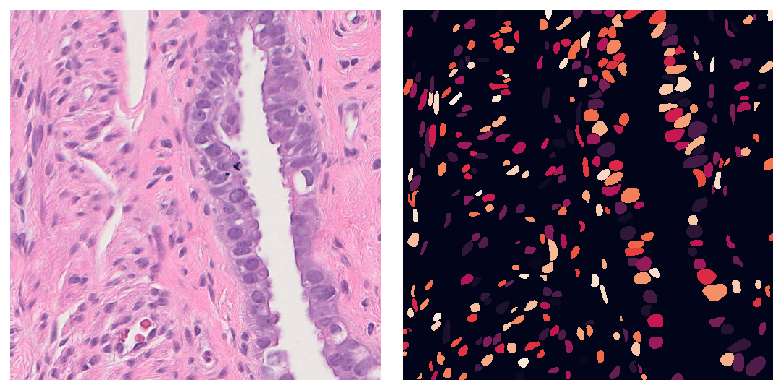

In [57]:
i += 1

img, lbl = val_tiles[i], val_masks[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
show_tile_segmented(img,lbl)

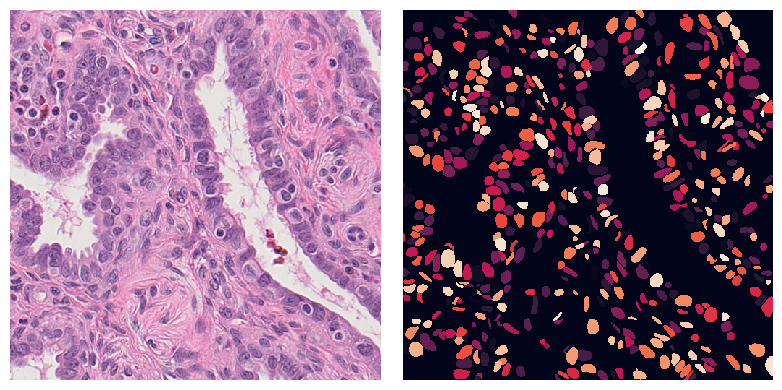

In [81]:
i += 10

img, lbl = HE_trn[i], mask_trn[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
show_tile_segmented(img,lbl)

In [82]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    
print(tf.__version__)

#Define the config by setting some parameter values
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

n_channel = 1 if HE_trn[0].ndim == 2 else HE_trn[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.


conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
# print(conf)
vars(conf)

GPU is available
2.9.3
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [83]:
#Start from 40x H&E pre-trained model to the specified directory
import copy
import json

def load_justin_model(folder_to_write_new_model_folder: str, name_for_new_model: str) -> StarDist2D:
    published_model = load_model(r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\Model_00')
    original_thresholds = copy.copy({'prob': published_model.thresholds[0], 'nms': published_model.thresholds[1]})
    configuration = Config2D(n_channel_in=3, grid=(2,2), use_gpu=True, train_patch_size=[256, 256])
    model = StarDist2D(config=configuration, basedir=folder_to_write_new_model_folder, name=name_for_new_model)
    model.keras_model.set_weights(published_model.keras_model.get_weights())
    model.thresholds = original_thresholds
    return model

def load_published_he_model(folder_to_write_new_model_folder: str, name_for_new_model: str) -> StarDist2D:
    published_model = StarDist2D.from_pretrained('2D_versatile_he')
    original_thresholds = copy.copy({'prob': published_model.thresholds[0], 'nms': published_model.thresholds[1]})
    configuration = Config2D(n_channel_in=3, grid=(2,2), use_gpu=True, train_patch_size=[256, 256])
    model = StarDist2D(config=configuration, basedir=folder_to_write_new_model_folder, name=name_for_new_model)
    model.keras_model.set_weights(published_model.keras_model.get_weights())
    model.thresholds = original_thresholds
    return model

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

def configure_model_for_training(model: StarDist2D,
                                 epochs: int = 25, learning_rate: float = 1e-6,
                                 batch_size: int = 4, patch_size: list[int,int] = [256, 256]) -> StarDist2D:
    model.config.train_epochs = epochs
    model.config.train_learning_rate = learning_rate
    model.config.train_batch_size = batch_size
    model.config.train_patch_size = patch_size
    return model

In [84]:
from tensorflow.python.summary.summary_iterator import summary_iterator

def get_loss_data(pth_training_log, pth_out) -> list:

    # event_file = r"\\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_02_2023_lr_1e-4_epochs_200_pt_10\logs\train\events.out.tfevents.1698964029.WPC-C13.20400.7.v2"

    loss_values = []

    for summary in summary_iterator(pth_training_log):
        for value in summary.summary.value:
            if value.tag == 'epoch_loss':
                loss = struct.unpack('f', value.tensor.tensor_content)[0]
                loss_values.append(loss)

    out_txt_name = f"{pth_out}\loss.txt"

    with open(out_txt_name, 'w') as f:
        f.write('\n'.join(map(str, loss_values)) + '\n')

    return loss_values

In [86]:
lr = 0.001
epochs = 200
patience = 40

nm='monkey_add_fallopian_test'
dt='_12_7_23'
outnm = nm + dt + '_lr_' + str(lr) + '_epochs_' + str(epochs) + '_pt_' + str(patience)
print(outnm)

monkey_add_fallopian_test_12_7_23_lr_0.001_epochs_200_pt_40


In [87]:
print(fr"{pthmodels}\{outnm}\logs\train")

\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_add_fallopian_test_12_7_23_lr_0.001_epochs_200_pt_40\logs\train


In [88]:
model = load_published_he_model(pthmodels, outnm)
model.config.train_learning_rate = lr
model.config.train_patch_size = (256,256)
model.config.train_reduce_lr={'factor': 0.5, 'patience': patience, 'min_delta': 0}
model.train(HE_trn, mask_trn, validation_data=(val_tiles,val_masks), epochs=epochs, steps_per_epoch=100)
model.optimize_thresholds(val_tiles, val_masks)

pth_log_train = fr"{pthmodels}\{outnm}\logs\train"
if not os.path.exists(pth_log_train): os.mkdir(pth_log_train)

pth_log = glob(os.path.join(pth_log_train,'*.v2'))[0]
loss = get_loss_data(str(pth_log), pth_log_train)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/200
Cause: Unable to locate the source code of <function _gcd_import at 0x0000029274CA1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000029274CA1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000029274CA1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 17s 83ms/step - loss: 0.5499 - prob_loss: 0.2243 - dist_loss: 1.6280 - prob_kld: 0.0909 - dist_relevant_mae: 1.6277 - dist_relevant_mse: 7.0294 - dist_dist_iou_metric: 0.6018 - val_loss: 0.5307 - val_prob_loss: 0.2372 - val_dist_loss: 1.4677 - val_prob_kld: 0.0798 - val_dist_relevant_mae: 1.4674 - val_dist_relevant_mse: 5.8767 - val_dist_dist_iou_metric: 0.6265 - lr: 0.0010
Epoch 2/200
100/100 [==============================] - 5

NameError: name 'HE_val' is not defined

In [90]:
pthHE= fr'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
pthmasks= fr'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

HE_tiles_val = list(map(imread,HE_tiles_pths))
mask_tiles_val = list(map(imread,mask_tiles_pths))

HE_tiles_val = [x/255 for x in HE_tiles_val]  # just divide by 255 to get into (0,1) range
mask_tiles_val = [fill_label_holes(y) for y in mask_tiles_val]  # fills holes in annotations if there are any

In [91]:
#Predict on validation images
mask_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_tiles_val)]

100%|██████████| 36/36 [00:01<00:00, 19.25it/s]


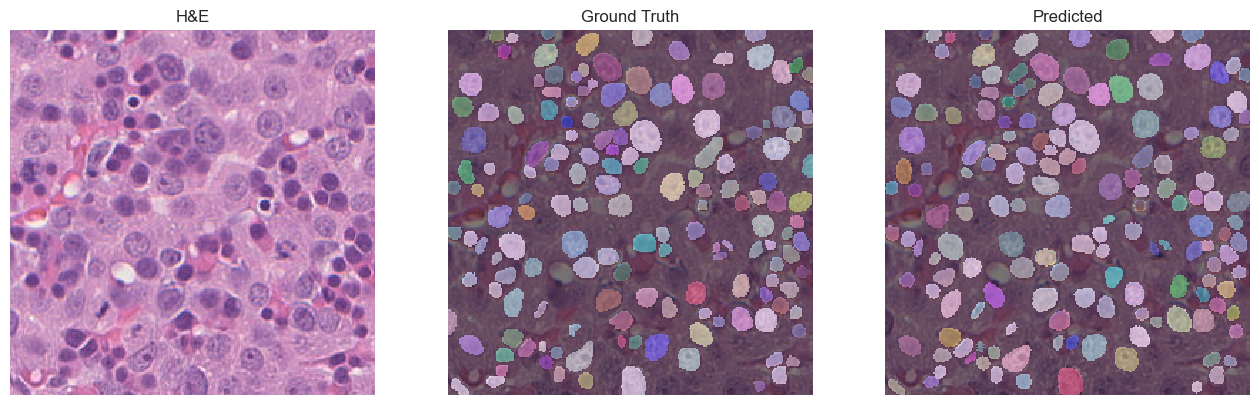

In [92]:
X_val = HE_tiles_val
Y_val_pred = mask_val_pred
Y_val = mask_tiles_val

ind = 3

cropped_img = X_val[ind]
cropped_lbl = Y_val_pred[ind]
cropped_lbl_gt = Y_val[ind]

fig, ax = plt.subplots(1,3,figsize = (16, 8))
ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl_gt, cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(cropped_img)
ax[2].imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.5)
ax[2].axis('off')
ax[2].set_title('Predicted')
plt.show()